<a href="https://colab.research.google.com/github/adityaprasad2005/ES335-assignment_2/blob/main/task2_audio_reconstruction_siren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center> **SIREN**: Sinusoidal Representation Networks
###### <center> _Sitzmann, V., Martel, J., Bergman, A., Lindell, D., and Wetzstein, G. 2020. [Implicit Neural Representations with Periodic Activation Functions](https://www.vincentsitzmann.com/siren/). In Proc. NeurIPS._

## <center> Audio Mapping Function
### $$ f(t): \mathbb{R} \to \mathbb{R} $$

### $$ \text{Cordinate Map}: \mathbb{R} \to \mathbb{R} : [t] \to [A] $$
### $$ \text{Feature Map}: \mathbb{R}^{\text{features}} \to \mathbb{R} : [t_{1 \cdots k}] \to [A] $$
### $$ \text{Final Map}: \mathbb{R} \to \mathbb{R}^{\text{features}} \to \mathbb{R} : [t] \to [t_{1 \cdots k}] \to [A] $$

<div align = "center">
    <img src = "./SIREN/1.png" style="float: left; width: 50%">
    <img src = "./SIREN/2.png" style="width: 50%">
</div>

### Run **only in Colab or Linux** to install Latex Fonts and add `latexify.py` in the upload files

In [ ]:
# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

# from latexify import latexify
# latexify(columns = 2)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


### Get the Audio File

In [ ]:
!wget https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav

--2025-01-07 10:13:08--  https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
Resolving www.vincentsitzmann.com (www.vincentsitzmann.com)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to www.vincentsitzmann.com (www.vincentsitzmann.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232886 (1.2M) [audio/wav]
Saving to: ‘gt_bach.wav’

gt_bach.wav         100%[===================>]   1.17M  --.-KB/s    in 0.09s   

2025-01-07 10:13:09 (13.2 MB/s) - ‘gt_bach.wav’ saved [1232886/1232886]



In [ ]:
from IPython.display import Audio
Audio('gt_bach.wav')

In [ ]:
import torchaudio
audio, sr = torchaudio.load('./gt_bach.wav')

print("sampling rate ", sr)
print("audio.shape ", audio.shape)
audio = audio[0]

sampling rate  44100
audio.shape  torch.Size([1, 308207])


$$ \text{Sampling Frequency} = \frac{\text{No. of Samples}}{\text{Time Taken}} $$

In [ ]:
audio.shape

torch.Size([308207])

In [ ]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 6.988820861678004 seconds


In [ ]:
audio

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0473, 0.0297, 0.0168])

In [ ]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

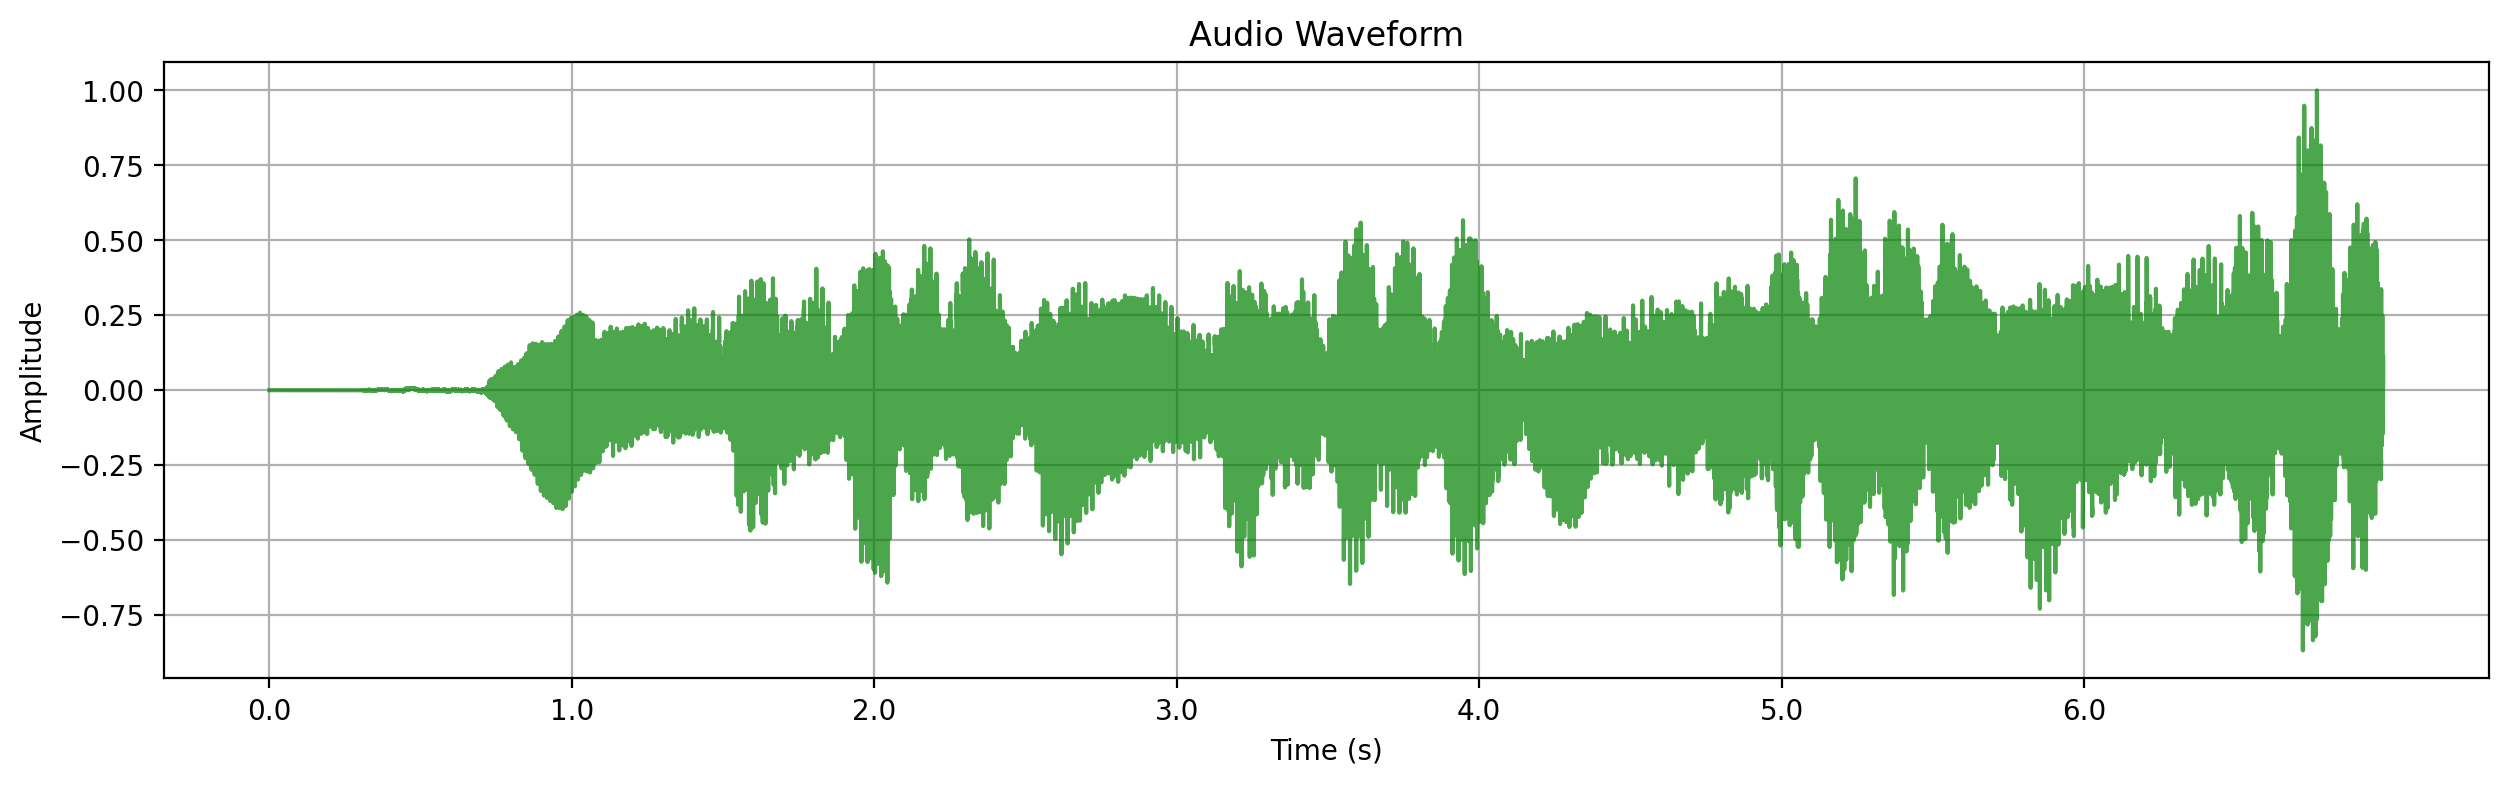

In [ ]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

### Using the last 2 seconds of the Audio

In [ ]:
audio_lt2 = audio[-2 * sr:]
print(audio_lt2.shape)
print(audio_lt2)

torch.Size([88200])
tensor([-0.0099,  0.0410,  0.0865,  ...,  0.0473,  0.0297,  0.0168])


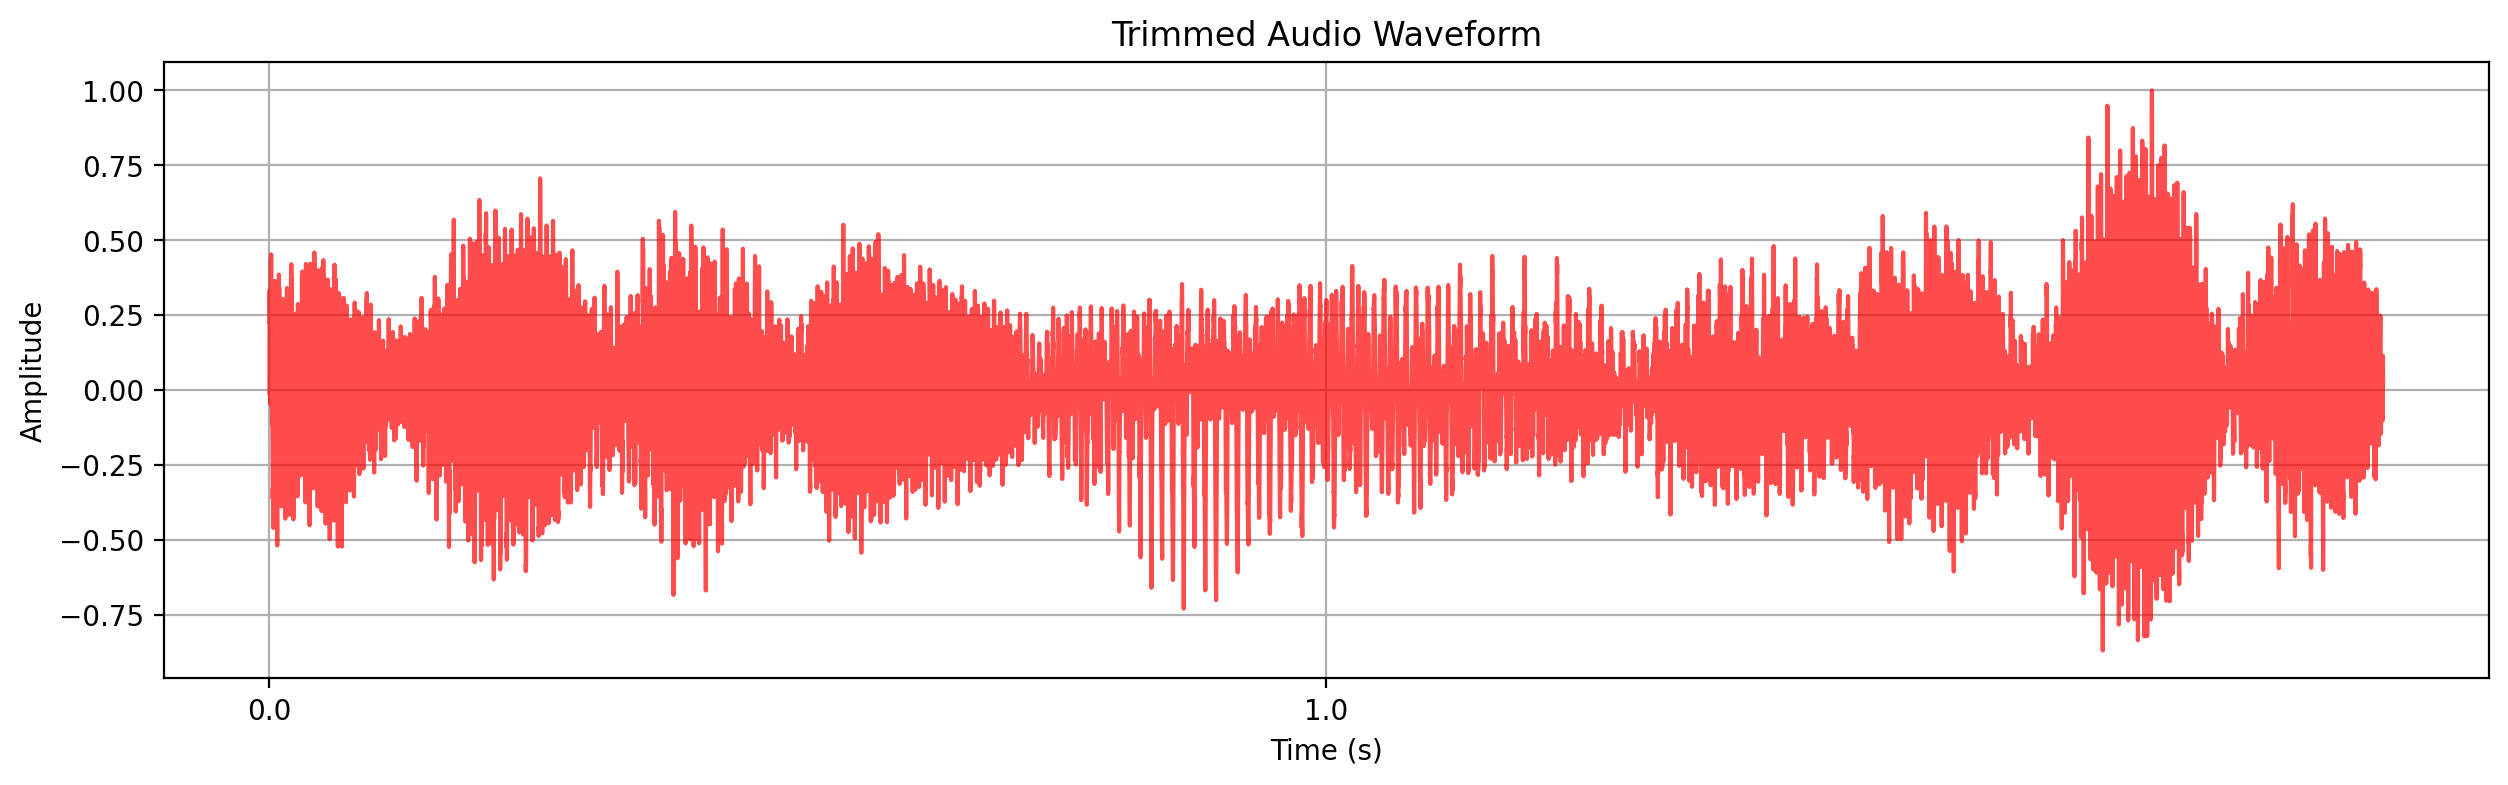

In [ ]:
audio_plot(audio_lt2, sr, 'red', 'Trimmed Audio Waveform')

In [ ]:
type(audio_lt2)
audio_lt2.shape[0]

88200

In [ ]:
torch.arange(10).unsqueeze(1)

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])

### Creating the Time Series $t = [-100.0, \cdots, 100.0]$ domain shifted to $[-100, 100]$

In [ ]:
X = torch.arange(0, audio_lt2.shape[0]).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([88200, 1])
tensor([[-100.0000],
        [ -99.9977],
        [ -99.9955],
        ...,
        [  99.9955],
        [  99.9977],
        [ 100.0000]])


In [ ]:
Audio(audio_lt2, rate = sr)

### Gaussian Kernel and Random Fourier Features

#### The Gaussian Kernel
$$ K(\textbf{x}, \textbf{x}') = \exp{(-\gamma \lVert \textbf{x} - \textbf{x}' \rVert^2)}, \gamma = \frac{1}{2\sigma^2}$$

#### Since this is infinte dimensional, it can approximated with the **Fourier Transform** of this kernel
###### _(Rahimi, A., & Recht, B. (2007). [Random features for large-scale kernel machines](https://papers.nips.cc/paper_files/paper/2007/hash/013a006f03dbc5392effeb8f18fda755-Abstract.html). Advances in Neural Information Processing Systems, 1177–1184.)_

$$\gamma(\mathbf{v}) = [\cos({2 \pi \mathbf{B}\mathbf{v}}), \sin({2 \pi \mathbf{B}\mathbf{v}})]^T $$
$$ \mathbf{v} \in \mathbb{R}^{\text{input}} $$
Each entry in $\mathbf{B} \in \mathbb{R}^{m \times \text{input}}$ is sampled from $\mathcal{N}(0, \sigma^2 I)$
$$ \gamma(\mathbf{v}) = [a_1 \cos({2 \pi \mathbf{b}_1^T\mathbf{v}}), a_1 \sin({2 \pi \mathbf{b}_1^T\mathbf{v}}), \cdots, a_m \cos({2 \pi \mathbf{b}_m^T\mathbf{v}}), a_m \sin({2 \pi \mathbf{b}_m^T\mathbf{v}})]^T $$

In [ ]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [ ]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([88200, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0050, -0.0194, -0.0189,  ..., -0.0198,  0.0093, -0.0090],
        [ 0.0011, -0.0200, -0.0189,  ..., -0.0199,  0.0113, -0.0124],
        ...,
        [-0.0141, -0.0200, -0.0148,  ...,  0.0045, -0.0043, -0.0085],
        [-0.0110, -0.0196, -0.0146,  ...,  0.0057, -0.0019, -0.0119],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


## Fit a Linear Model over this expanded feature domain
### $\textbf{X}_{(88200, 5000)}, \textbf{y}_{(88200, )}$

In [ ]:
audio_lt2.shape

torch.Size([88200])

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio_lt2)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(88200,)


### On saving the model weights and sound file

In [ ]:
import joblib
# joblib library, which is used for saving and loading Python objects, including machine learning models.

joblib.dump(model, 'lr_audio_model.pkl')
model = joblib.load('lr_audio_model.pkl')
# This line saves the trained machine learning model (stored in the variable model) to a file named model.pkl.
# The .pkl extension is commonly used for files containing pickled (serialized) Python objects. This allows you to save the model and reuse it later without retraining.

import soundfile as sf
# soundfile library, which is used for reading and writing audio files.

sf.write('pred_audio_lt2.wav', pred_audio, sr)

In [ ]:
print(pred_audio)
print(audio)

[-0.11193104 -0.07676193 -0.04065947 ... -0.07884325 -0.09824581
 -0.11784156]
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0473, 0.0297, 0.0168])


### Reconstruction Losses ($L_1$ and $L_2$)
$$ L_1 = \lVert \text{Reconstructed} - \text{Original} \rVert_1 $$
$$ L_2 = \lVert \text{Reconstructed} - \text{Original} \rVert_2 $$

In [ ]:
l2_norm = np.linalg.norm(pred_audio - audio.numpy())   # calculates l2-norm by default

l1_norm = np.linalg.norm((pred_audio - audio.numpy()), ord = 1)   # calculates l1-norm or Mahattan norm

print(l2_norm)
print(l1_norm)

(40.0905, 9472.825)

## Reconstructed Audio

In [ ]:
Audio(pred_audio, rate = sr)

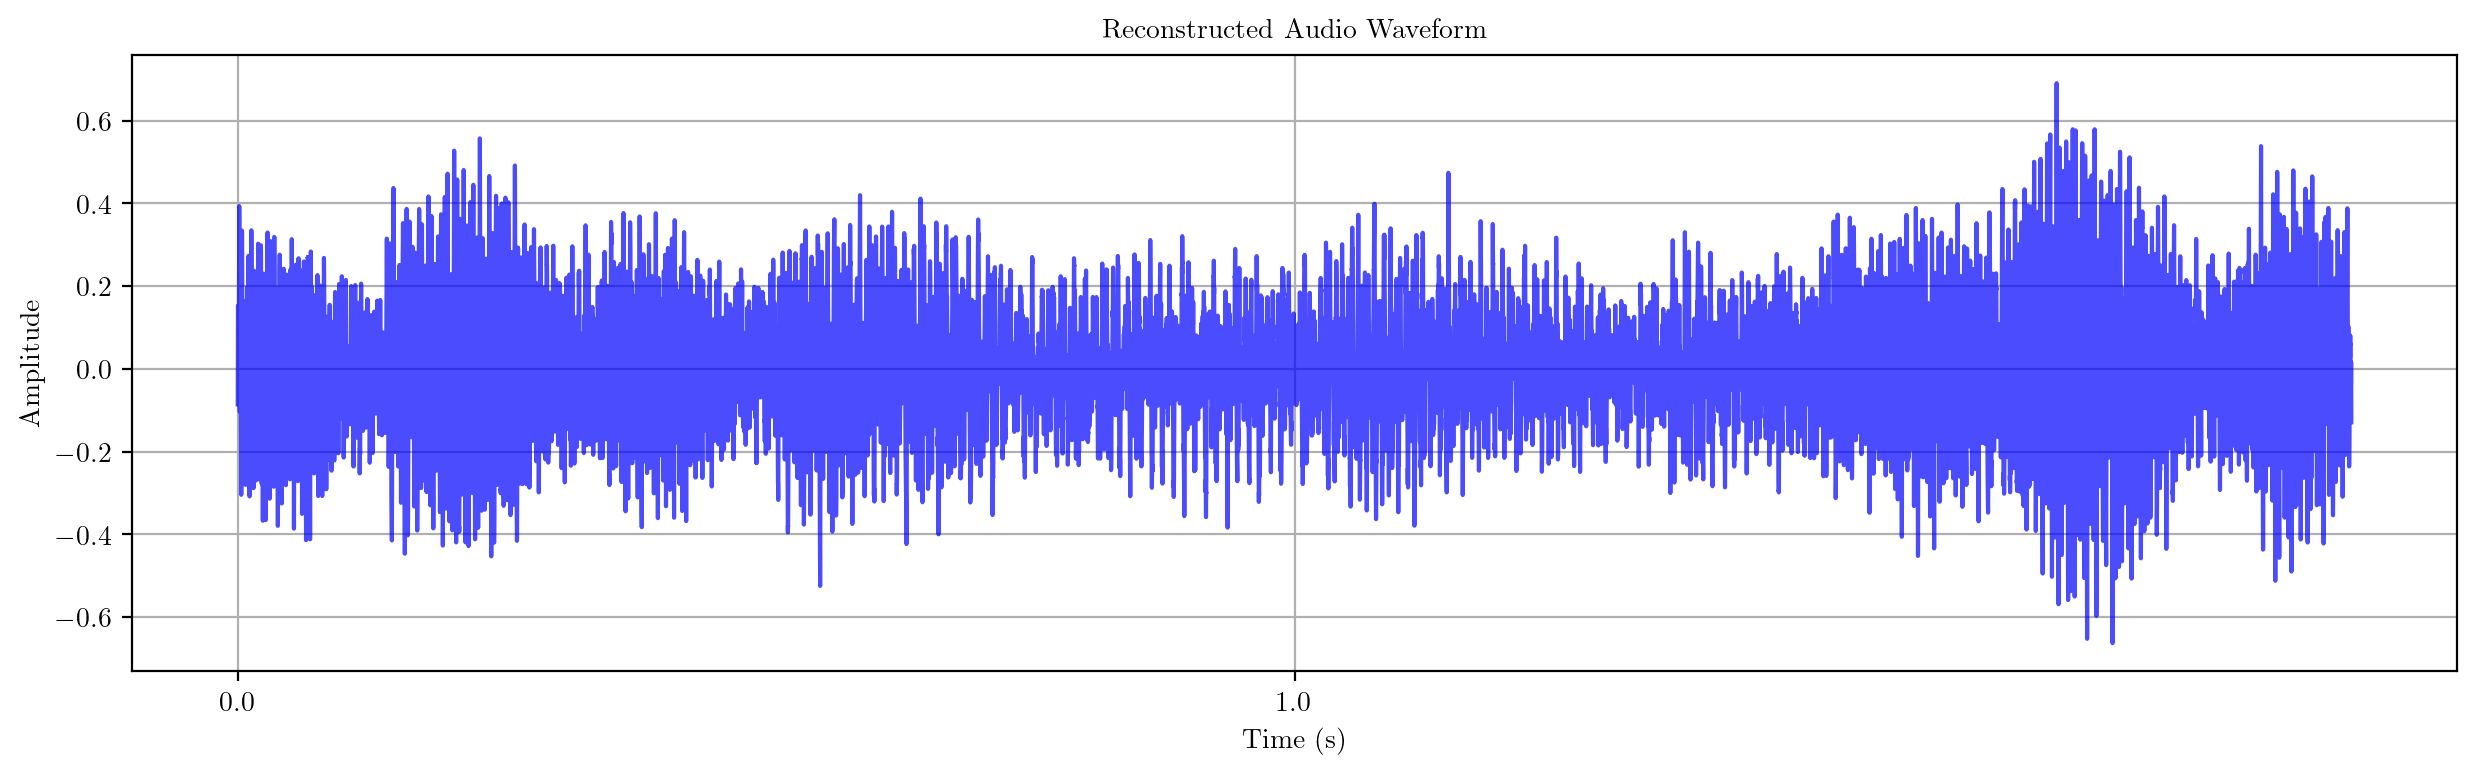

In [ ]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

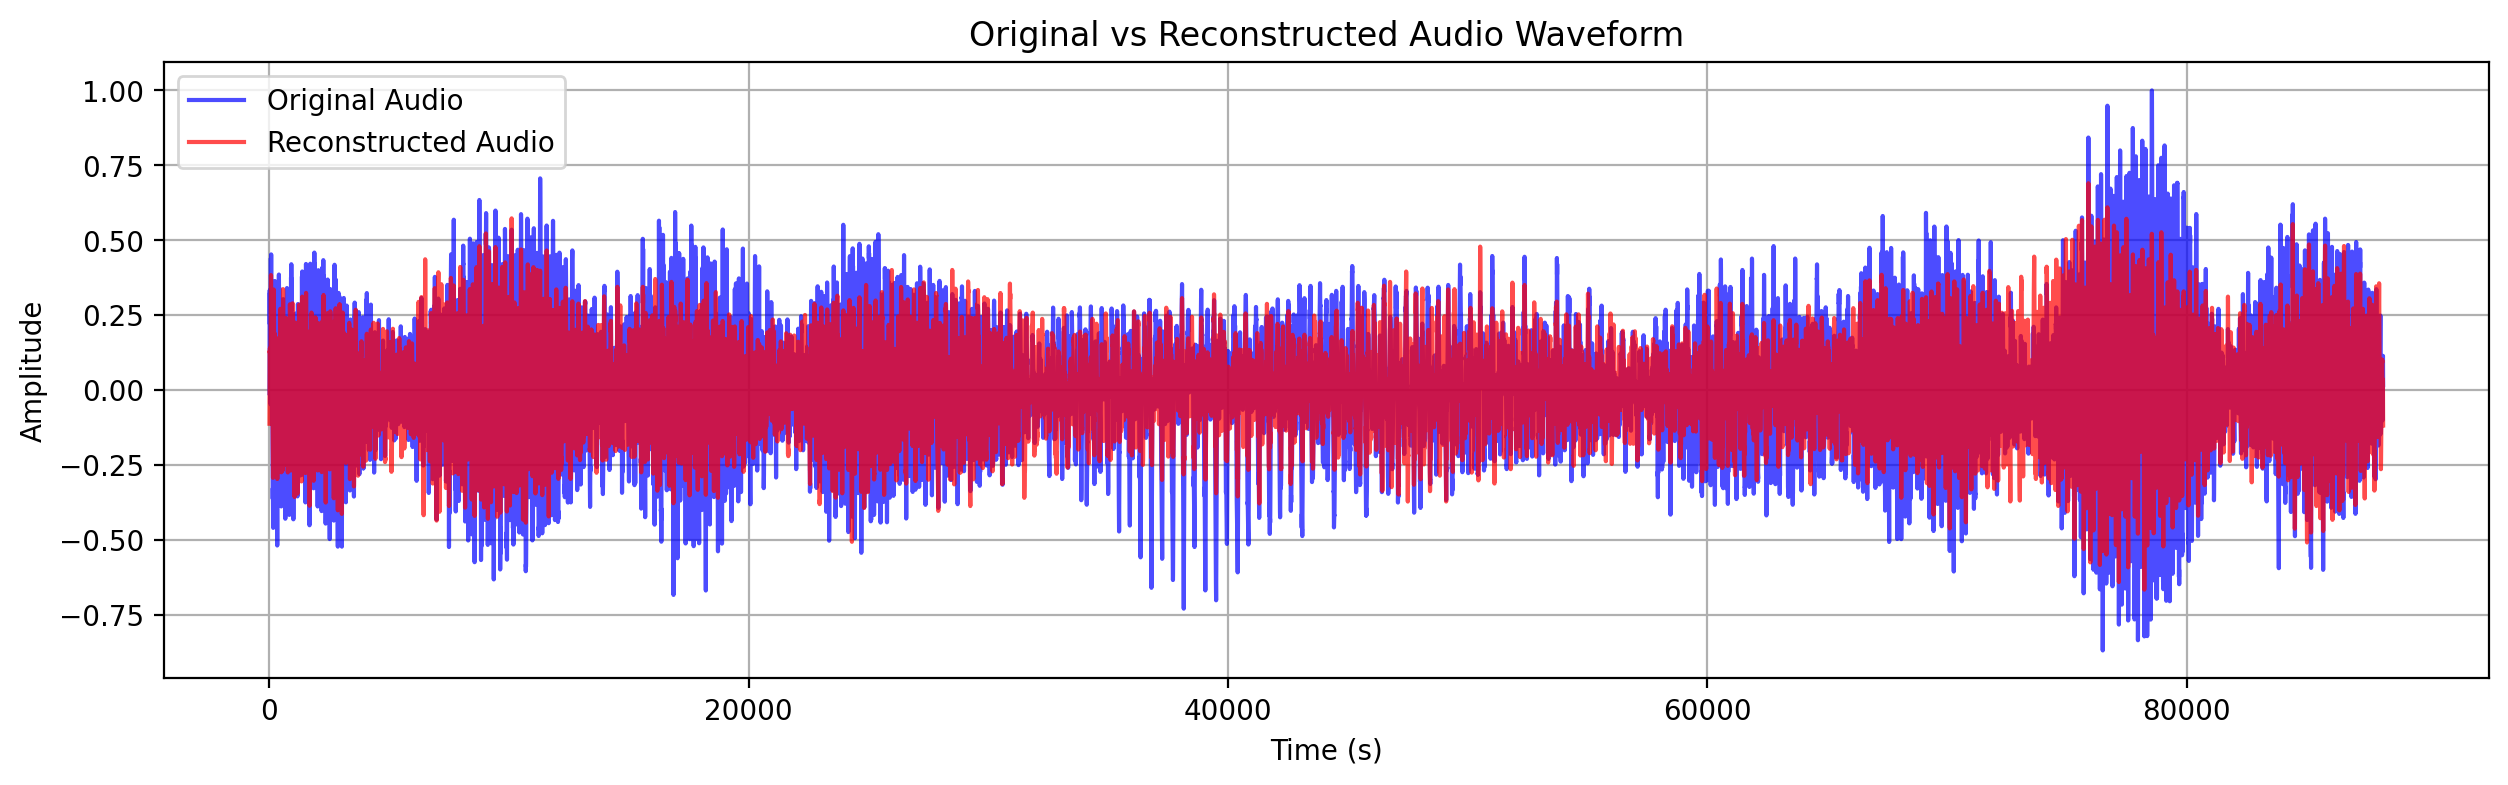

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(audio_lt2, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

### Interpolation

#### We remove out 10,000 continuous samples from the time series
#### $\textbf{X}_{(:\text{start}, 5000) \cup (\text{end}:, 5000)}, \textbf{y}_{(:\text{start},) \cup (\text{end}:,)}$

<div align = "center">
    <img src = "./SIREN/3.png" style="width: 65%;">
</div>

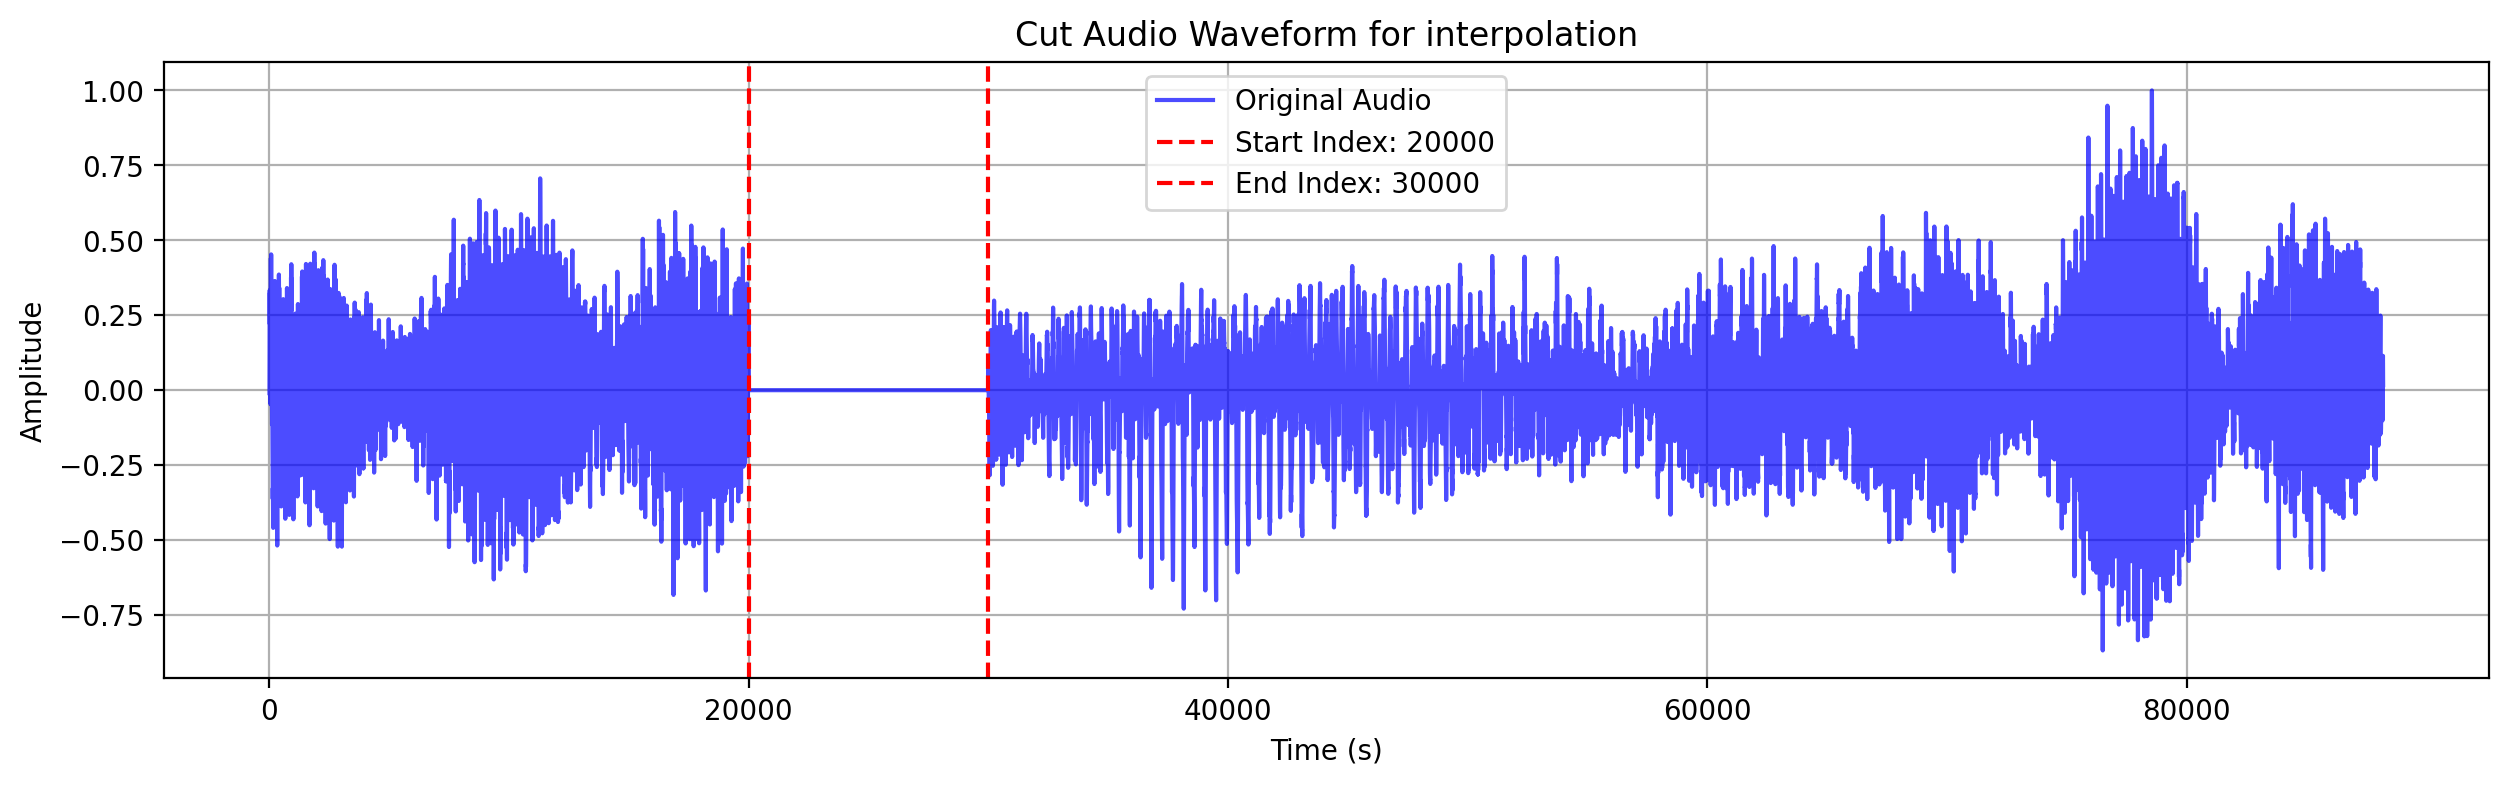

In [ ]:
start_idx = 20000
end_idx = 30000

audio_new = audio_lt2.clone()
audio_new[start_idx : end_idx] = 0

plt.figure(figsize=(15, 4))
plt.plot(audio_new, color = 'blue', alpha = 0.7, label = 'Original Audio')

plt.axvline(start_idx, color = 'red', linestyle = '--', label = f'Start Index: {start_idx}')
plt.axvline(end_idx, color = 'red', linestyle = '--', label = f'End Index: {end_idx}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Cut Audio Waveform for interpolation')
plt.grid()
plt.legend()
plt.show()

#### Extract out the $\textbf{X}[:\text{start}]$ $\textbf{X}[\text{end}:]$, $\textbf{y}[:\text{start}]$  $\textbf{y}[\text{end}:]$ and then concatentate them

In [ ]:
X_rff1 = X_rff[:start_idx]
X_rff2 = X_rff[end_idx:]

audio1 = audio_lt2[:start_idx]
audio2 = audio_lt2[end_idx:]

# concate X_rff1 and X_rff2
X_rffF = torch.cat((X_rff1, X_rff2), dim = 0)

# concate audio1 and audio2
audioF = torch.cat((audio1, audio2), dim = 0)

In [ ]:
print(X_rffF.shape)
print(audioF.shape)

torch.Size([78200, 5000])
torch.Size([78200])


### Fit the Linear model on the left out portion `X_rffF`

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rffF.numpy(), audioF)

LinearRegression()

### But predict on the entire `X_rff`

In [ ]:
pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(88200,)


In [ ]:
print(pred_audio)
print(audio_lt2)

[-0.04894212 -0.01978518  0.01057701 ... -0.04709523 -0.05686556
 -0.0666251 ]
tensor([-0.0099,  0.0410,  0.0865,  ...,  0.0473,  0.0297,  0.0168])


In [ ]:
l2_norm = np.linalg.norm(pred_audio - audio_lt2.numpy())

l1_norm = np.linalg.norm((pred_audio - audio_lt2.numpy()), ord = 1)

print(l2_norm)
print(l1_norm)

47.158325
10477.508


### Interpolated Audio

In [ ]:
Audio(pred_audio, rate = sr)

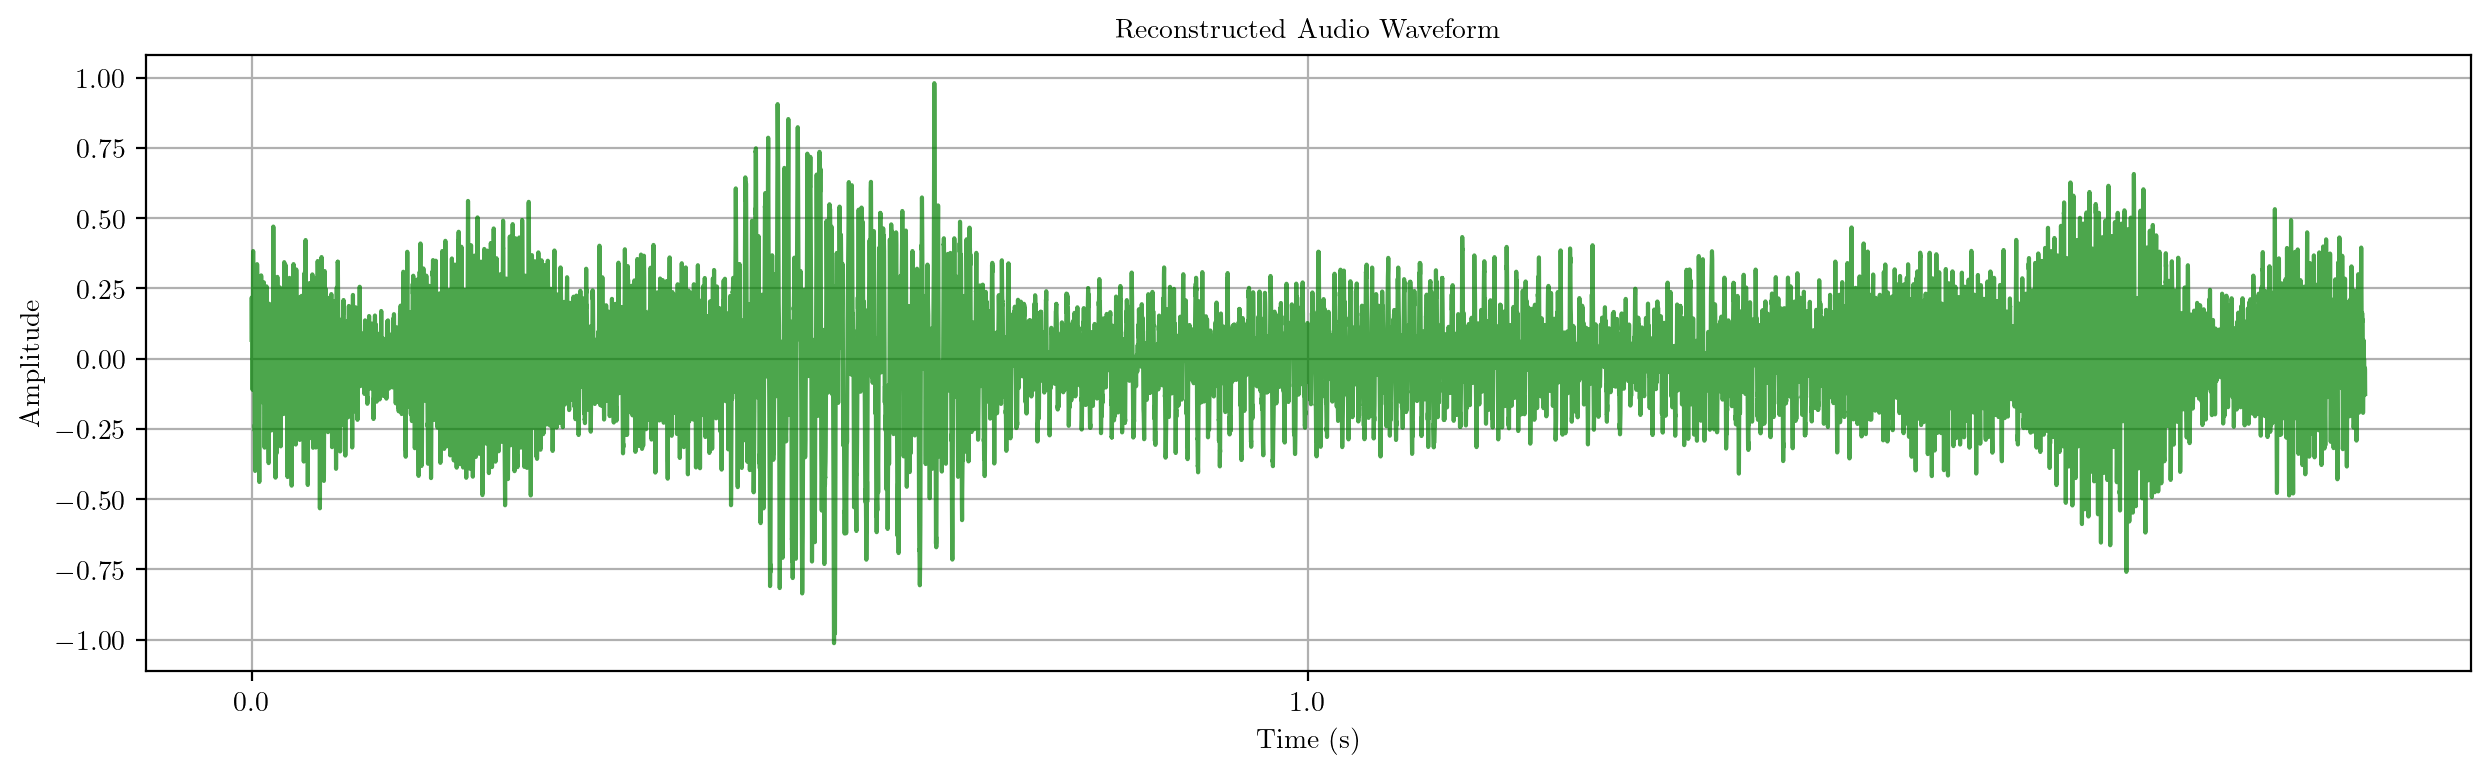

In [ ]:
audio_plot(pred_audio, sr, 'green', 'Reconstructed Audio Waveform')

### Comparison of original waveform to interpolated reconstructed audio

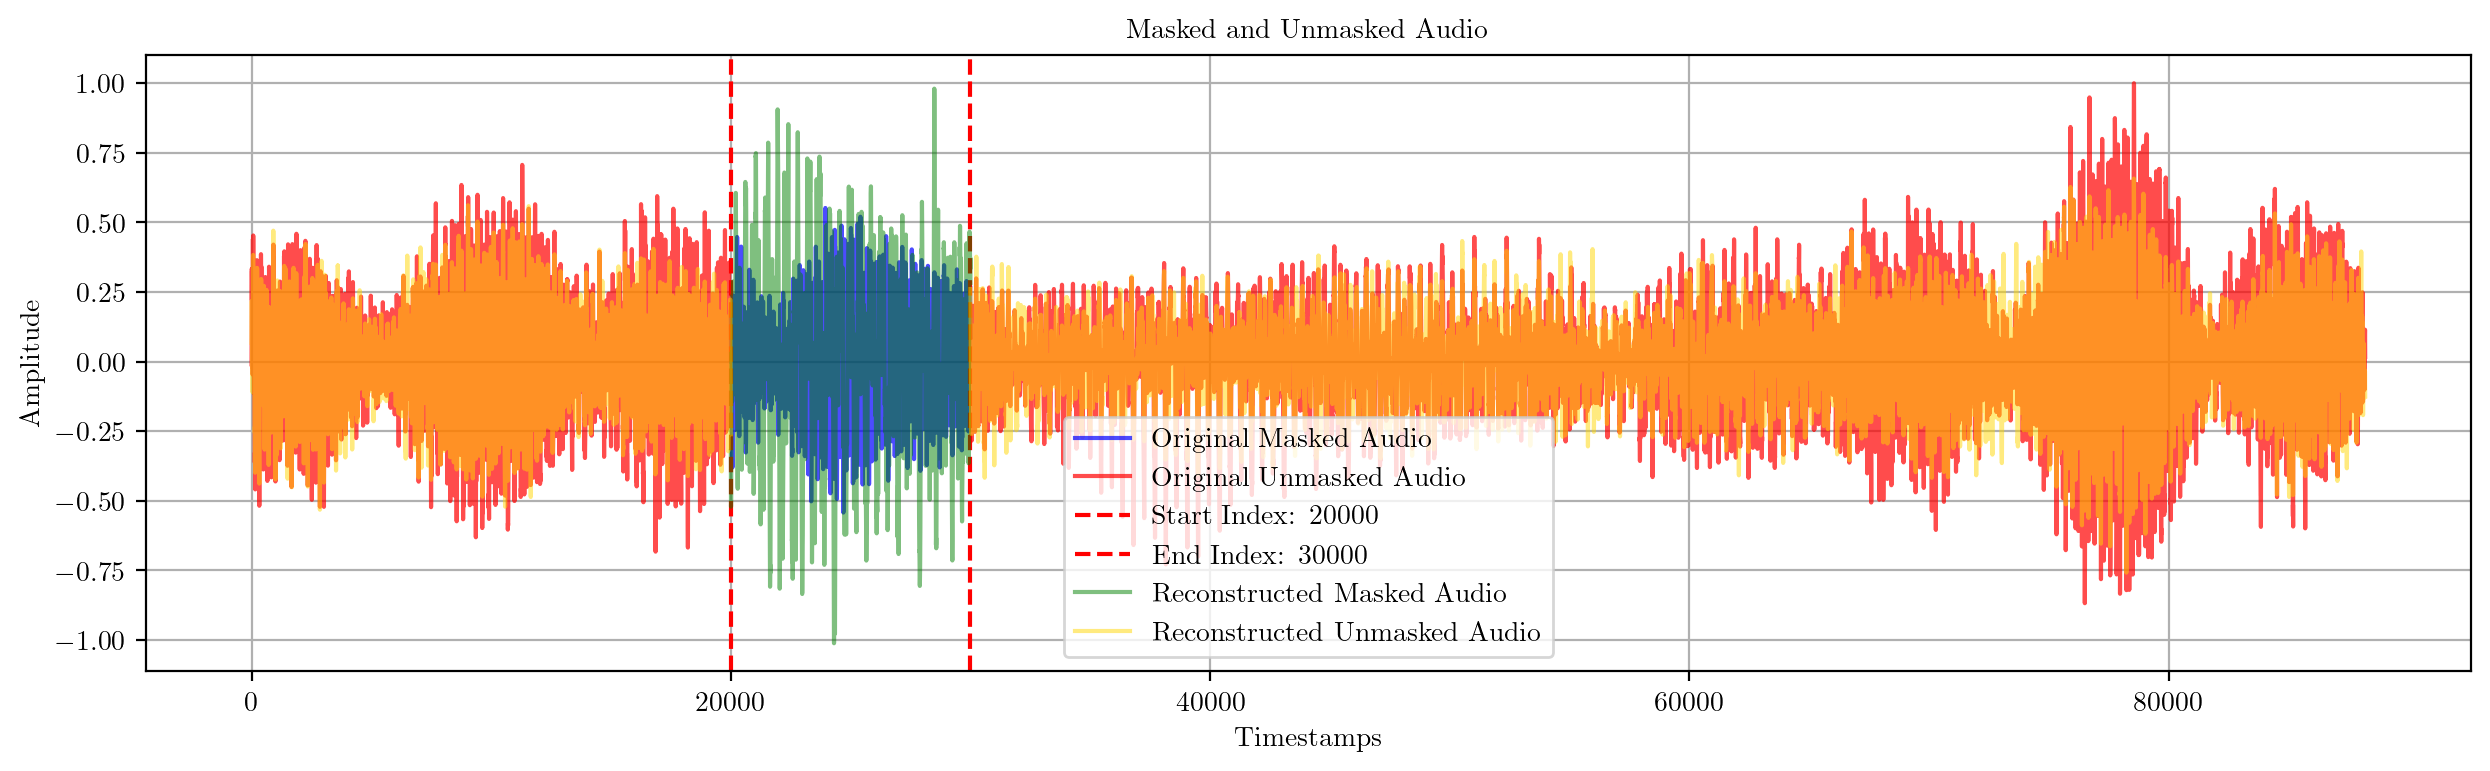

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(start_idx,end_idx), audio[start_idx:end_idx].numpy(), color = 'blue', alpha = 0.7, label = 'Original Masked Audio')
plt.plot(np.arange(start_idx), audio[:start_idx], color = 'red', alpha = 0.7, label = 'Original Unmasked Audio')
plt.plot(np.arange(end_idx, X.shape[0]), audio[end_idx:], color = 'red', alpha = 0.7)

plt.axvline(start_idx, color = 'red', linestyle = '--', label = f'Start Index: {start_idx}')
plt.axvline(end_idx, color = 'red', linestyle = '--', label = f'End Index: {end_idx}')

plt.plot(np.arange(start_idx,end_idx), pred_audio[start_idx : end_idx], color = 'green', alpha = 0.5, label = 'Reconstructed Masked Audio')
plt.plot(np.arange(start_idx), pred_audio[:start_idx], color = 'gold', alpha = 0.5, label = 'Reconstructed Unmasked Audio')
plt.plot(np.arange(end_idx, X.shape[0]), pred_audio[end_idx:], color = 'gold', alpha = 0.5)

plt.xlabel('Timestamps')
plt.ylabel('Amplitude')
plt.title('Masked and Unmasked Audio')
plt.grid()
plt.legend()
plt.show()

### If trained on Raw Time Series Domain

In [ ]:
model = LinearRegression()
model.fit(X, audio_lt2)

pred_audio1 = model.predict(X)
print(pred_audio1.shape)

(88200,)


## **Line** will be the prediction

In [ ]:
print(pred_audio1)
print(audio_lt2)

[ 2.9926197e-04  2.9925804e-04  2.9925414e-04 ... -4.5768102e-05
 -4.5772031e-05 -4.5775931e-05]
tensor([-0.0099,  0.0410,  0.0865,  ...,  0.0473,  0.0297,  0.0168])


In [ ]:
l2_norm = np.linalg.norm(pred_audio1 - audio_lt2.numpy())
l1_norm = np.linalg.norm((pred_audio1 - audio_lt2.numpy()), ord = 1)

print(l2_norm)
print(l1_norm)

61.98879
14268.9795


In [ ]:
Audio(pred_audio1, rate = sr)

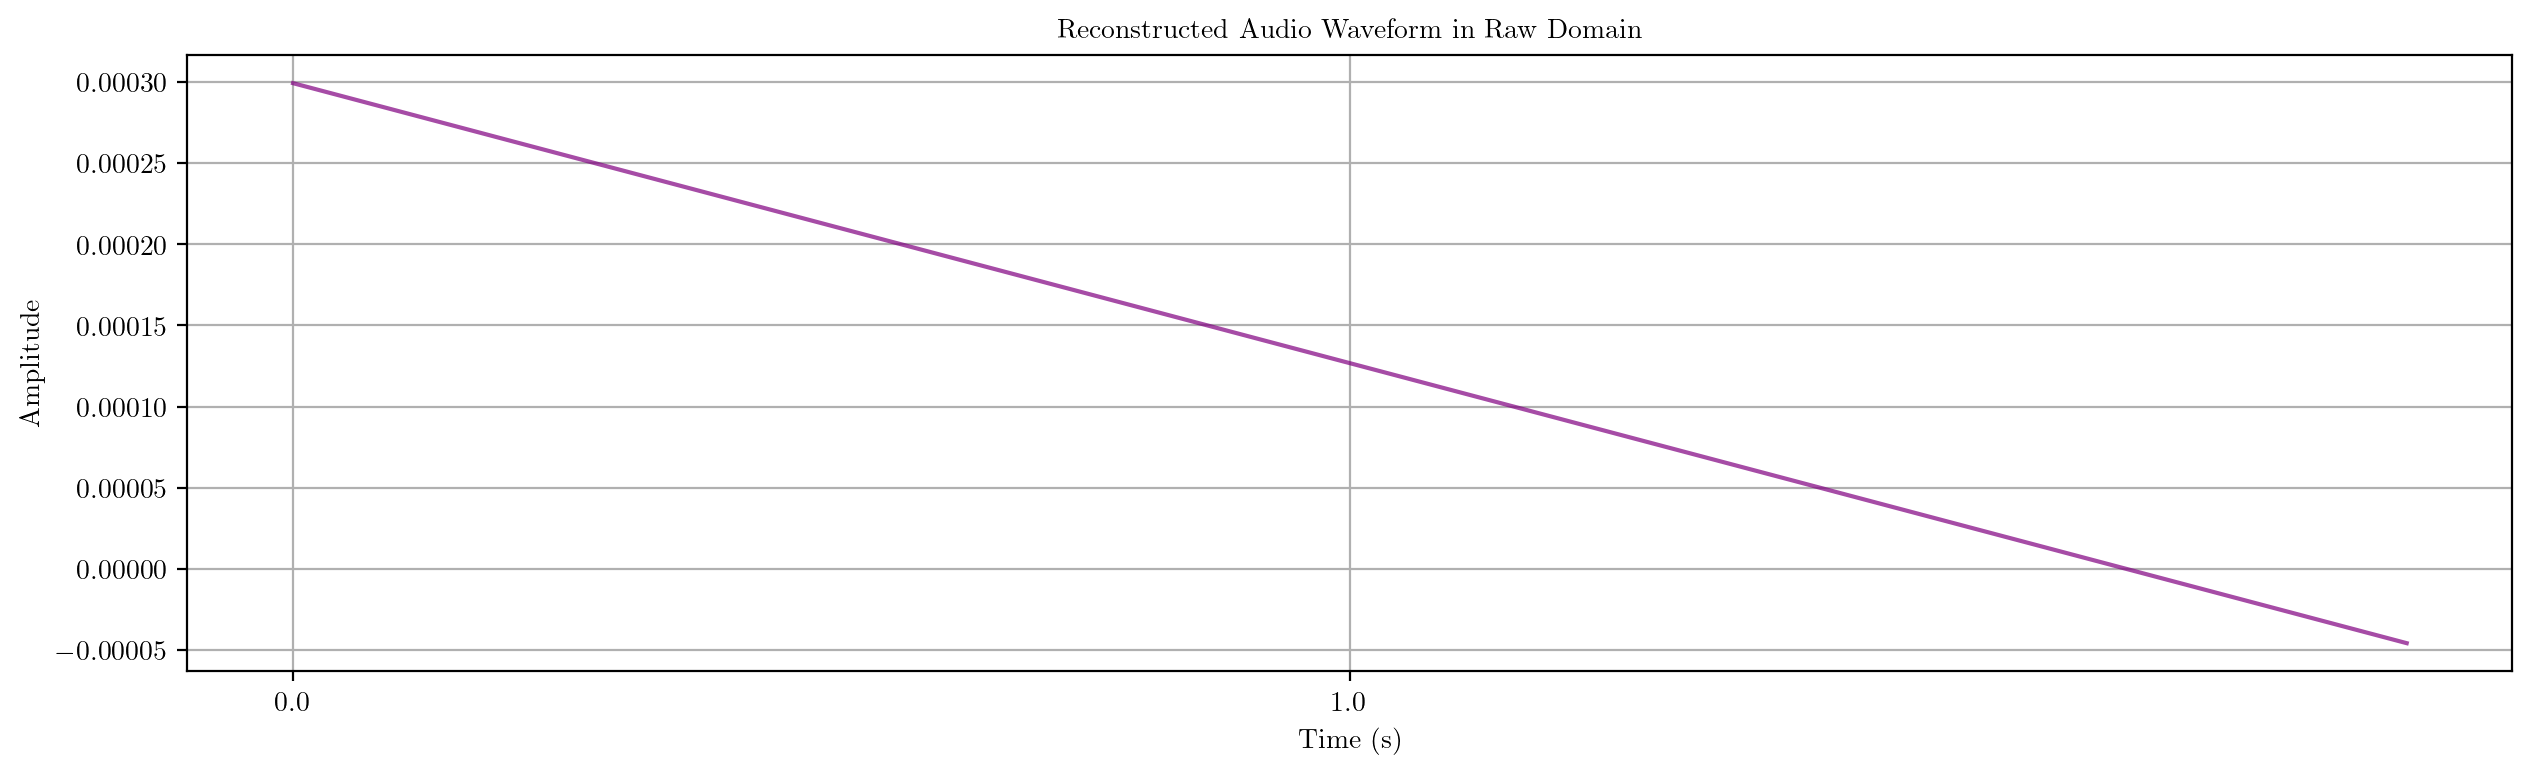

In [ ]:
audio_plot(pred_audio1, sr, 'purple', 'Reconstructed Audio Waveform in Raw Domain')

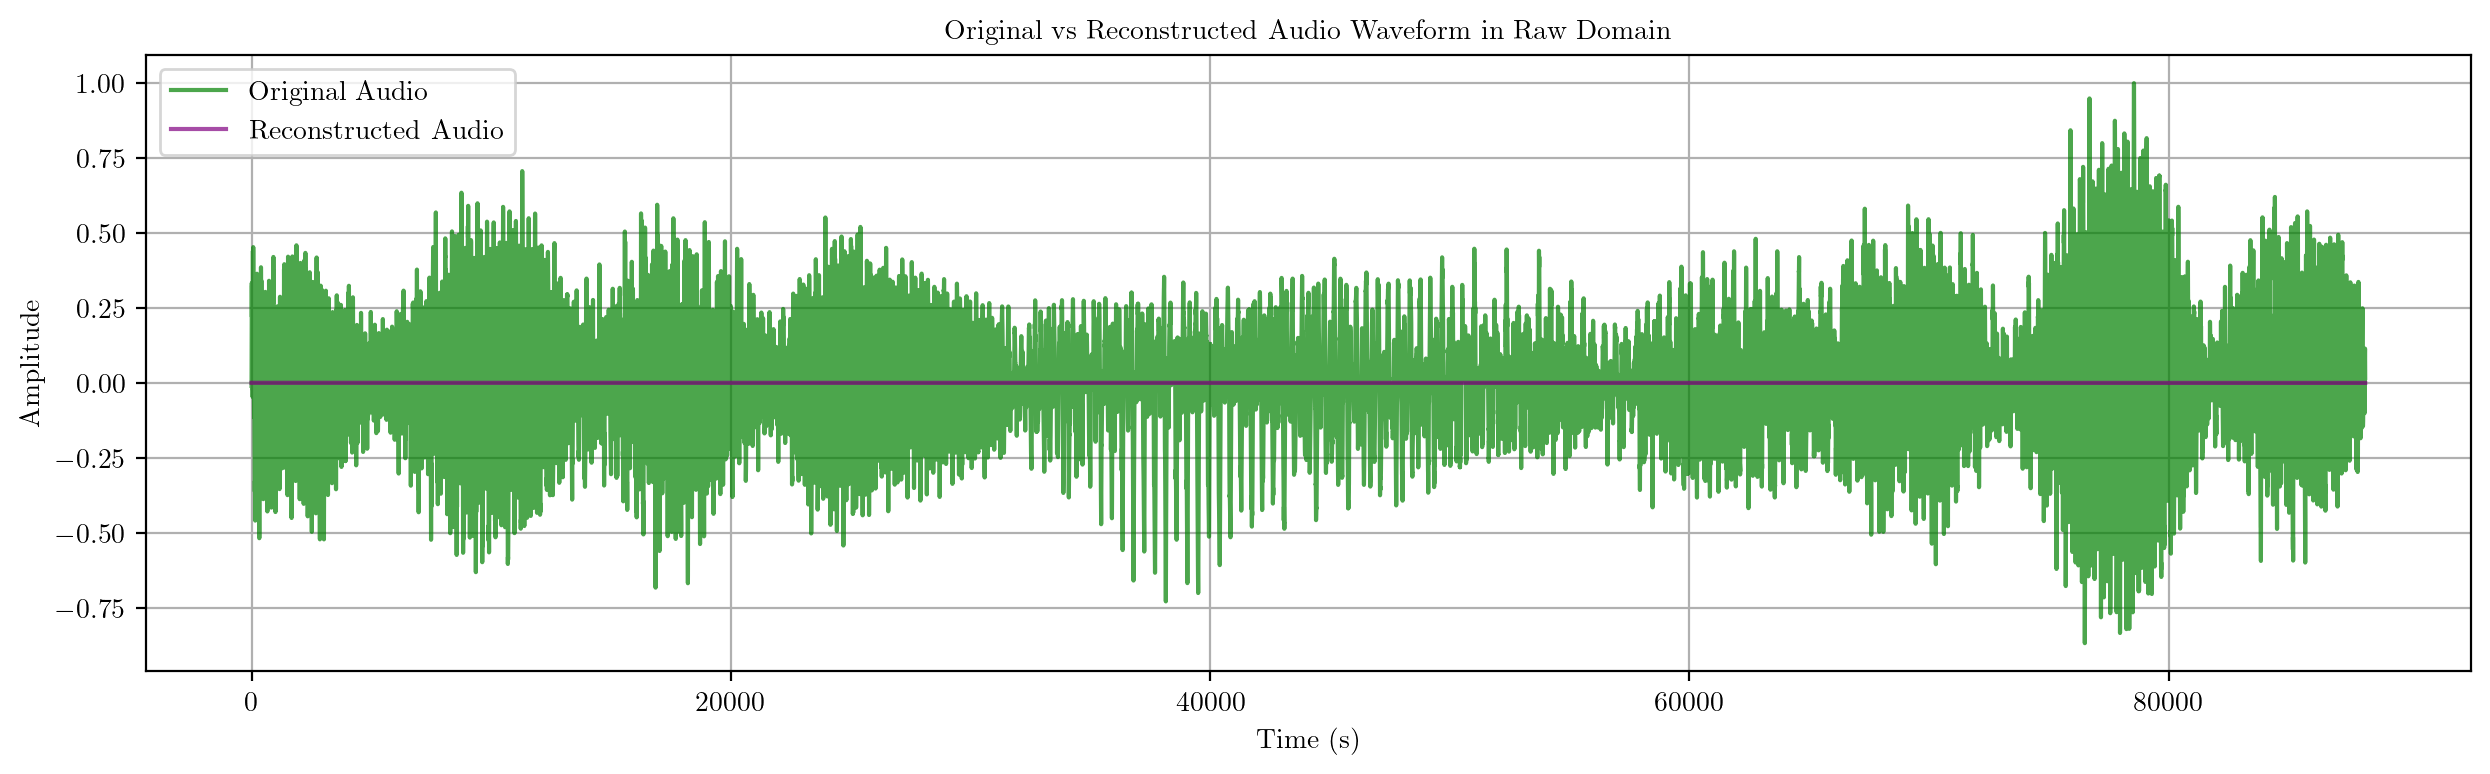

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'green', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio1, color = 'purple', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform in Raw Domain')
plt.grid()
plt.legend()
plt.show()